In [33]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm
from scipy import sparse

import netket as nk
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import json

### Generate Table of All Possible States Indexed in Lexigraphical Order

In [34]:
def generateStateTable(n,n0,N): # assumes ab > n0 > 0 and N = n choose n0
    states = []
    state = np.concatenate((np.ones(n-n0),-1*np.ones(n0))).astype(int)
    for i in range(0,N):
        states.append(np.copy(state))
        j = 0
        flag = True
        flip_count = 0
        up_count = 0
        while (flag): 
            if (j == n-1):
                for m in range(0,n):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                if (flip_count == 1):
                    break
            if (state[j] != 1):
                j += 1  
            elif (state[j+1] != 1):
                for m in range(0,j):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                    if (state[m] == 1):
                        up_count += 1
                if (flip_count == 1):
                    state[j],state[j+1] = state[j+1],state[j]
                    for k in range(1,up_count+1):
                        state[j-k],state[k-1] = state[k-1],state[j-k]
                else:
                    state[j],state[j+1] = state[j+1],state[j]
                flag = False
            else:
                j += 1
    return states

In [35]:
def squareAdjacencyTensor(a,b): # Z^2 quotient out by the smallest bounding box of (a,b)+(c,d) (non periodic)
    J = np.full((a,b,a,b),False)

    # first neighbors
    for i in range(0,a):
        for j in range(0,b):
            for k in range(0,a):
                for l in range(0,b):
                    if ((np.abs(i-k) == 1 and j == l) or (np.abs(j-l) == 1 and i == k)):
                        J[i][j][k][l] = True

    return J

def solveLinearSystem(v1,v2,b): # returns x,y satisfying alpha*v1+beta*v2=b assuming v1 and v2 are linear independent
    A = np.transpose(np.array([v1,v2]))
    return np.dot(np.linalg.inv(A),b)

def coeffMatrix(v1,v2): # Z^2/([x,y]-[a,b],[x,y]-[c,d])
    a,b = v1
    c,d = v2

    x = np.abs(a)+np.abs(c) # bounding box width
    y = np.abs(b)+np.abs(d) # bounding box height
    J_bool = squareAdjacencyTensor(x+1,y+1)
    
    # merge degenerate nodes
    for i in range(0,x+1):
        for j in range(0,y+1):
            for k in range(i,x+1):
                for l in range(j,y+1):
                    sol = solveLinearSystem(v1,v2,[i-k,j-l])
                    if (sol[0].is_integer() and sol[1].is_integer() and (sol[0] != 0 or sol[1] != 0)):
                        for m in range(0,x+1):
                            for n in range(0,y+1):
                                J_bool[k][l][m][n] = J_bool[i][j][m][n] or J_bool[k][l][m][n]
                                J_bool[i][j][m][n] = False

    # enforce boundary conditions
    for i in range(0,x+1):
        for j in range(0,y+1):
            for k in range(i,x+1):
                for l in range(j,y+1):
                    sol = solveLinearSystem(v1,v2,[i-k,j-l])
                    if (sol[0].is_integer() and sol[1].is_integer() and (sol[0] != 0 or sol[1] != 0)):
                        for m in range(0,x+1):
                            for n in range(0,y+1):
                                temp = J_bool[m][n][i][j] or J_bool[m][n][k][l]
                                J_bool[m][n][i][j],J_bool[m][n][k][l] = temp,temp
                                
    J = []

    for i in range(0,x+1):
        for j in range(0,y+1):
            J.append(list(1*J_bool[i][j].flatten())) 

    i,j = 0,0
    while (i < len(J)):
        total = 0
        j = 0
        while (j < len(J[0])):
            total += J[i][j]
            j += 1
        if (total == 0):
            for j in range(0,len(J[0])):
                J[j].pop(i)
            J.pop(i)
            i,j = 0,0
        else:
            i += 1
        
    return np.array(J)

### Model Parameters

In [36]:
v1 = [5,0] # first basis vector
v2 = [0,4] # second basis vector
J = coeffMatrix(v1,v2)
n = len(J) # number of sites in lattice

n0 = n // 2 # number of down spins in the string (taken as floor(n/2))
N = int(math.factorial(n)/(math.factorial(n0)*math.factorial(n-n0))) # number of states

stateTable = generateStateTable(n,n0,N)

print(n)
print(J)

20
[[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


### Compute Hamiltonian of the System

In [37]:
def computeHamiltonian():
    # uses the fact that the Hamiltonian is real and Hermitian => symmetric
    row = []
    col = []
    data = []

    for i in range(0,N):
        for j in range(i,N):
            if (i == j):
                for k in range(0,n-1):
                    for l in range(k,n):
                        if (J[k][l] != 0):
                            row.append(i)
                            col.append(j)
                            data.append(J[k][l]*stateTable[i][k]*stateTable[i][l])
            else:
                tempState = np.multiply(stateTable[i],stateTable[j])
                if (np.count_nonzero(tempState == -1) == 2):
                    indices = np.where(tempState == -1)
                    e,f = indices[0][0],indices[0][1]
                    if(J[e][f] != 0):
                        row.append(i)
                        col.append(j)
                        data.append(2*J[e][f])
                        row.append(j)
                        col.append(i)
                        data.append(2*J[e][f])
    
    H = sparse.coo_array((data, (row, col)), shape=(N,N), dtype=np.int8)
    return H

startTime = time.time()
H = computeHamiltonian()
endTime = time.time()

print(H.toarray())
print(endTime-startTime)


[[20  2  0 ...  0  0  0]
 [ 2 16  2 ...  0  0  0]
 [ 0  2 20 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  2  0]
 [ 0  0  0 ...  2 16  2]
 [ 0  0  0 ...  0  2 20]]
50209.5426466465


### Save Hamiltonian

In [ ]:
PATH = os.getcwd()
sparse.save_npz(PATH + '/hamiltonian.npz', H, compressed=True)

### Load Hamiltonian

In [ ]:
# H = sparse.load_npz(PATH + '/n20hamiltonian.npz')

### Visualize Sparse Hamiltonian Matrix

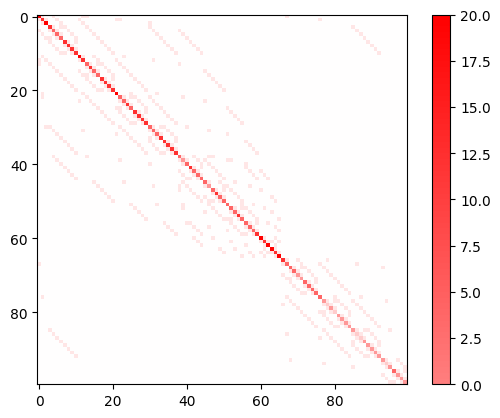

In [45]:
csrH = H.tocsr()

def sparsePlot(A):
    norm = TwoSlopeNorm(vcenter=0)
    plt.imshow(A,cmap=colors.LinearSegmentedColormap.from_list("", ["purple","white","red"]),interpolation=None,norm=norm)
    plt.colorbar()

sparsePlot(csrH[0:100,0:100].toarray())

### Exact Diagonalization

In [39]:
numEnergies = 100

energies, states = sparse.linalg.eigs(H.asfptype(), k=numEnergies, which='SR')

energies = np.real(energies)
states = np.real(states)

print(energies[0])

-53.230827


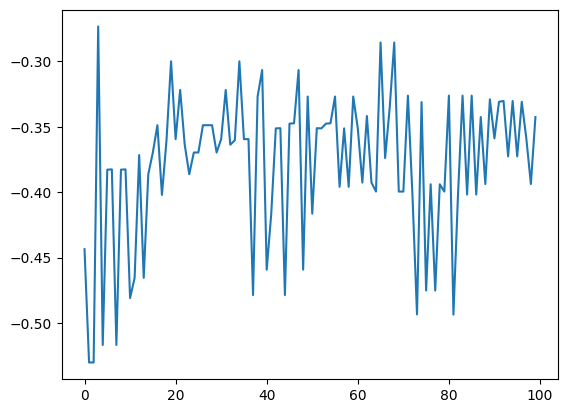

In [40]:
def spinCorrelation(states,n):
    spin_corr = 0
    for i in range(0,len(states)):
        spin_corr += (states[i][n]**2)*csrH[i,i]

    numNeighbors = 0
    for i in range(0,len(J)):
        for j in range(0,len(J[0])):
            numNeighbors += J[i][j]
    spin_corr /= (numNeighbors/2)
    return spin_corr

spinCorrelations = []

for i in range(0,numEnergies):
    spinCorrelations.append(spinCorrelation(states,i))

plt.plot(np.array(spinCorrelations))

### Compare Results to NetKet

In [44]:
lattice = nk.graph.Grid(extent=[4,5], pbc=True)
hilbertSpace = nk.hilbert.Spin(s=0.5, total_sz=0.5*(n-2*n0), N=n)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbertSpace, graph=lattice)

netketH = hamiltonian.to_sparse()

evals = nk.exact.lanczos_ed(hamiltonian)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

The exact ground-state energy is E0= -53.23078872065257


### Visualize Lattices

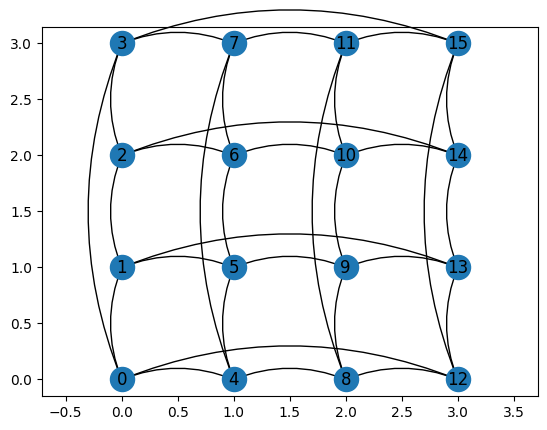

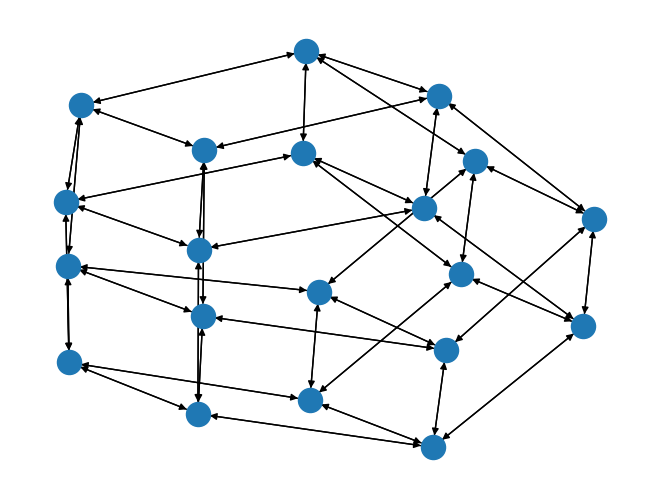

In [42]:
lattice.draw()
plt.show()

import networkx as nx 
G = nx.DiGraph() 

for i in range(np.shape(J)[0]): 
 for j in range(np.shape(J)[0]): 
   if J[i][j] != 0: 
      G.add_edge(i,j) 
nx.draw(G) 
plt.show()